# Propensity Score

The propensity score is just a dimensional reduction tool

Theorem: Consider the ignorability assumption in Causal Inference which states ${Y(1), Y(0) \perp T_{i}} \mid X$, meaning once we know $X$, knowing the treatment assignment $T_{i}$ does not give us any additional information about the potential outcomes $Y(1)$ and $Y(0)$. Then, if strong ignorability holds conditional on X, then it also holds conditional on the scalar propensity score $e(X) = P(T_{i} = 1 \mid X)$. That is, if ${Y(1), Y(0) \perp T_{i}} \mid X$, then ${Y(1), Y(0) \perp T_{i}} \mid e(X)$. We can easily prove it (applying LIE), but it is not necessary.

The propensity score $e(X) = P(T_{i} = 1 \mid X)$ is a balancing score, meaning that it balances the covariates $X$ between the treatment and control groups.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [4]:
# read the data
data = pd.read_csv("data/learning_mindset.csv")
data.head()

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277359,...,-1.310927,0.224077,-0.426757
1,76,1,-0.449646,...,-1.310927,0.224077,-0.426757
2,76,1,0.769703,...,-1.310927,0.224077,-0.426757
3,76,1,-0.121763,...,-1.310927,0.224077,-0.426757
4,76,1,1.526147,...,-1.310927,0.224077,-0.426757


In [5]:
data.columns

Index(['schoolid', 'intervention', 'achievement_score', 'success_expect',
       'ethnicity', 'gender', 'frst_in_family', 'school_urbanicity',
       'school_mindset', 'school_achievement', 'school_ethnic_minority',
       'school_poverty', 'school_size'],
      dtype='object')

In [6]:
data.shape

(10391, 13)

***
### Data Description:

The dataset in question pertains to the "National Study of Learning Mindsets," a randomized research study conducted in U.S. public high schools. Its primary objective is to investigate the impact of instilling a growth mindset in students. In this study, students were exposed to seminars aimed at fostering a growth mindset, and their academic performance in subsequent college years was assessed, resulting in standardized achievement scores.

In addition to the treated and outcome variables, the dataset includes various other relevant features:

* `schoolid`: An identifier for each student's school.
* `success_expect`: Self-reported expectations for future success, serving as a proxy for prior achievement, measured prior to random assignment.
* `ethnicity`: A categorical variable indicating the student's race/ethnicity.
* `gender`: A categorical variable reflecting the student's identified gender.
* `frst_in_family`: A categorical variable identifying whether a student is the first in their family to attend college (first-generation status).
* `school_urbanicity`: A categorical variable representing the urbanicity level of the school, such as rural, suburban, etc.
* `school_mindset`: The school-level mean of students' fixed mindsets, reported before random assignment and standardized.
* `school_achievement`: School achievement level, measured through test scores and college preparation for the preceding four cohorts of students, standardized.
* `school_ethnic_minority`: School racial/ethnic minority composition, denoting the percentage of the student body that is Black, Latino, or Native American, standardized.
* `school_poverty`: School poverty concentration, indicating the percentage of students from families with incomes falling below the federal poverty line, standardized.
* `school_size`: The total number of students across all four grade levels in the school, standardized.

This dataset is a simulated version of the original data, with statistical properties matching those provided by Athey and Wager, as the real data is not publicly available to safeguard students' privacy. Researchers can use this dataset to explore various factors' influence on academic performance and the effectiveness of growth mindset interventions in a high school setting.

***

In this dataset, even though the opportunity to participate was random, participation itself is not (non-compliance?). One can argue that there exists selection bias here: students who chose to participate in the study may be different from those who did not. For example, students who chose to participate may be more motivated to learn, and thus may have higher achievement scores. This is a problem because we want to estimate the effect of the treatment on the outcome, but the participation is not randomly assigned. We can use the propensity score to adjust for this selection bias.

In [7]:
# count the number of participants in each intervention group
data.groupby("intervention").size()

intervention
0    7007
1    3384
dtype: int64

In [8]:
# Students with higher self-reported high expectations are more likely to have joined the growth mindset seminar.
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

it's hard to compare the results of students who got the treatment and those who didn't. Why? Because the students who are more ambitious are more likely to take the treatment and achieve more in life.

But, if I pick two people, one who got the treatment and one who didn't, and they both had the same chance of getting the treatment, then they are comparable. This means that the only reason one got the treatment and the other didn't is just "luck".

So, when we keep this "chance of getting treatment" (propensity score) the same, it's like making the data look `as good as random`. It helps us make fair comparisons between treated and non-treated individuals.


***

## Propensity Score Weighting

The idea is to weight the data so that the treated and control groups look similar. We can do this by weighting each observation by the inverse of its propensity score. This is called `propensity score weighting`.

$$
E[Y \mid X, T=1]-E[Y \mid X, T=0]=E\left[\frac{Y}{e(x)} \mid X, T=1\right] P(T)-E\left[\frac{Y}{(1-e(x))} \mid X, T=0\right](1-P(T))
$$

The first term is estimating $Y_{1}$. It is taking all those that are treated and scaling them by the inverse probability of treatment. What this does is it makes those with very low probability of treatment have a high weight. This makes sense, right? If someone has a low probability of treatment, that individual looks like the untreated. However, that same individual was treated.

In [9]:
# estimation of propensity score

categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [10]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315488
1,1,-0.449646,0.263777
2,1,0.769703,0.344036
3,1,-0.121763,0.344036
4,1,1.526147,0.367799


In [11]:
# check the balance of the covariates
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.448526252736
Untreated Population Sample Size 10391.479853445446


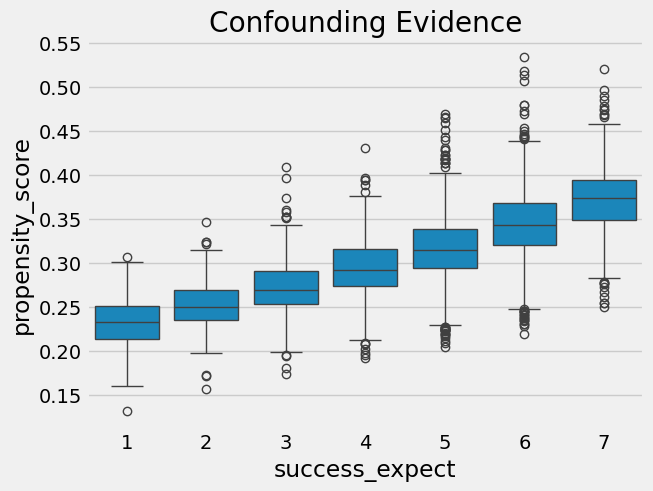

In [12]:
# confounding evidence
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

In [13]:
# perform estimation
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.2595954309963804
Y0: -0.12893079239879937
ATE 0.3885262233951796


***

## Double Robust Estimation

The idea is to use both the propensity score and the outcome model to estimate the treatment effect. This is called `double robust estimation`.

Instead of deriving the estimator, let us consider:
$$
A \hat{T} E=\frac{1}{N} \sum\left(\frac{T_i\left(Y_i-\hat{\mu_1}\left(X_i\right)\right)}{\hat{P}\left(X_i\right)}+\hat{\mu_1}\left(X_i\right)\right)-\frac{1}{N} \sum\left(\frac{\left(1-T_i\right)\left(Y_i-\hat{\mu_0}\left(X_i\right)\right)}{1-\hat{P}\left(X_i\right)}+\hat{\mu}_0\left(X_i\right)\right)
$$
where $\hat{P}(x)$ is an estimation of the propensity score (using logistic regression, for example), $\hat{\mu}_1(x)$ is an estimation of $E[Y \mid X, T=1]$ (using linear regression, for example), and $\hat{\mu_0}(x)$ is an estimation of $E[Y \mid X, T=0]$. The first part of the doubly robust estimator estimates $E\left[Y_1\right]$ and the second part estimates $E\left[Y_0\right]$. 

In [14]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [17]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

dr = doubly_robust(data_with_categ, X, T, Y)
print("ATE:", dr)

ATE: 0.388220886631817
